In [50]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.metrics import roc_auc_score, average_precision_score


FOLDER_PATH = "/home/juan/Work/Midterm project/splited/"
X_PATH = os.path.join(FOLDER_PATH, "X_data.npz")
Y_PATH = os.path.join(FOLDER_PATH, "Y_data.npz")
COLS_PATH = os.path.join(FOLDER_PATH, "feature_names.json")

# --- PART 1: DATA PREPARATION (Run only if NPZ files don't exist) ---
if not os.path.exists(X_PATH) or not os.path.exists(Y_PATH):
    print("NPZ files not found. Starting processing of CSV files...")
    
    FILE_PATTERN = os.path.join(FOLDER_PATH, "processed_*.csv")
    files = sorted(glob.glob(FILE_PATTERN))
    print(f"Found {len(files)} processed files.")

    if len(files) == 0:
        raise FileNotFoundError("No 'processed_*.csv' files found in the directory.")

    # 1. Read first file to determine column structure
    print("Reading headers from first file...")
    first_df = pd.read_csv(files[0], nrows=5)
    cols = first_df.columns
    x_cols = [c for c in cols if c.startswith("x ")]
    y_cols = [c for c in cols if c.startswith("y ")]
    
    # Save feature names for later use (Feature Importance)
    with open(COLS_PATH, 'w') as f:
        json.dump(x_cols, f)

    print(f"Detected {len(x_cols)} Features and {len(y_cols)} Targets.")

    X_list = []
    Y_list = []

    # 2. Loop through all files and convert to Sparse
    for f in files:
        print(f"Converting: {os.path.basename(f)}")
        df = pd.read_csv(f)
        
        x_data = df[x_cols].fillna(0).values.astype(np.float32)
        y_data = df[y_cols].fillna(0).values.astype(np.float32)
        
        X_list.append(sparse.csr_matrix(x_data))
        Y_list.append(sparse.csr_matrix(y_data))
        
        del df, x_data, y_data # Free RAM

    # 3. Stack and Save
    print("Stacking matrices...")
    X_final = sparse.vstack(X_list)
    Y_final = sparse.vstack(Y_list)

    print(f"Saving to {FOLDER_PATH}...")
    sparse.save_npz(X_PATH, X_final)
    sparse.save_npz(Y_PATH, Y_final)
    print("Processing complete.")

else:
    print("Found existing NPZ files. Skipping CSV processing.")

# --- PART 2: LOAD DATA & PREPARE FOR MODELING ---
print("Loading Data from disk...")
# --- RELOAD DATA TO ENSURE FRESH START ---
print("Loading Data...")
# Assuming X_PATH and Y_PATH are defined as before
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

print(f"Input Shape: {X.shape}")
print(f"Target Shape: {Y.shape}") # Should be (661271, 10488)

# Split the SPARSE matrices directly
# We do not densify yet to save RAM
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data Split Complete.")

# Load feature names if needed later
if os.path.exists(COLS_PATH):
    with open(COLS_PATH, 'r') as f:
        feature_names = json.load(f)
else:
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# 1. Select Target (Most Frequent Reaction)
# Sum columns to find which reaction happens most often
col_sums = np.array(Y.sum(axis=0)).flatten()
target_idx = np.argmax(col_sums)
y_target = Y[:, target_idx].toarray().ravel()

print(f"Target Index selected: {target_idx}")
print(f"Positive Cases: {int(sum(y_target))} / {len(y_target)}")

# 2. Calculate Class Weight (for imbalanced learning)
pos_count = sum(y_target)
neg_count = len(y_target) - pos_count
scale_weight = neg_count / (pos_count + 1e-5)
print(f"Calculated Class Weight (neg/pos): {scale_weight:.2f}")

# 3. Train/Test Split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)

# --- PART 3: EVALUATION SETUP ---
results_table = []
roc_curves = {}

from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# Initialize dictionaries to store curve data
roc_curves = {}
pr_curves = {}   
results_table = []

def log_result(name, y_true, y_prob):
    # 1. Calculate Metrics
    y_prob = np.nan_to_num(y_prob)
    
    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # PR-AUC (Average Precision)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    # F1 Score 
    y_pred = (y_prob > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred)
    
    # 2. Log Scalar Results
    results_table.append({
        "Model": name, 
        "ROC-AUC": roc_auc, 
        "PR-AUC": pr_auc,  
        "F1": f1
    })
    
    # 3. Store Curve Data for Plotting
    roc_curves[name] = (fpr, tpr, roc_auc)
    pr_curves[name] = (recall, precision, pr_auc) 
    
    print(f"✅ {name}: ROC-AUC={roc_auc:.4f} | PR-AUC={pr_auc:.4f}")

print("\nSetup Complete. Data is ready fZor training models.")

Found existing NPZ files. Skipping CSV processing.
Loading Data from disk...
Loading Data...
Input Shape: (661271, 5286)
Target Shape: (661271, 10488)
Data Split Complete.
Target Index selected: 4309
Positive Cases: 52505 / 661271
Calculated Class Weight (neg/pos): 11.59
Splitting data...

Setup Complete. Data is ready fZor training models.


In [51]:
import torch
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sparse
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero, Linear
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
# Update these paths to match your actual file locations
FOLDER_PATH = "/home/juan/Work/Midterm project/splited/"
X_PATH = FOLDER_PATH + "X_data.npz"
Y_PATH = FOLDER_PATH + "Y_data.npz"

print("Loading Data...")
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

# Get dimensions
num_patients = X.shape[0]
num_input_features = X.shape[1] # Treated as 'Drug' nodes
num_reactions = Y.shape[1]      # Treated as 'Reaction' nodes

print(f"Patients: {num_patients}")
print(f"Input Nodes (Drugs/Feats): {num_input_features}")
print(f"Output Nodes (Reactions): {num_reactions}")

# Split data (using indices to keep memory usage low)
indices = np.arange(num_patients)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

Loading Data...
Patients: 661271
Input Nodes (Drugs/Feats): 5286
Output Nodes (Reactions): 10488


In [53]:
class HeteroGraphDataset(Dataset):
    def __init__(self, X, Y, indices, num_input_nodes, num_output_nodes):
        self.X = X
        self.Y = Y
        self.indices = indices
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):

        return self.indices[idx]

def graph_collate_fn(batch_indices):

    batch_indices = sorted(batch_indices)
    

    x_sub = X[batch_indices]
    y_sub = Y[batch_indices] 
    
    batch_size = len(batch_indices)

    rows_d, cols_d = x_sub.nonzero()
    edge_index_drug = torch.stack([torch.from_numpy(rows_d), torch.from_numpy(cols_d)]).long()
    

    rows_r, cols_r = y_sub.nonzero()
    edge_index_react = torch.stack([torch.from_numpy(rows_r), torch.from_numpy(cols_r)]).long()
    

    data = HeteroData()
    

    data['patient'].x = torch.ones((batch_size, 1), dtype=torch.float)
    data['patient'].num_nodes = batch_size
    

    data['drug'].num_nodes = num_input_features
    data['reaction'].num_nodes = num_reactions
    
    # Edges
    data['patient', 'takes', 'drug'].edge_index = edge_index_drug
    data['patient', 'has_reaction', 'reaction'].edge_index = edge_index_react
    

    data['drug', 'taken_by', 'patient'].edge_index = torch.flip(edge_index_drug, [0])
    data['reaction', 'reaction_in', 'patient'].edge_index = torch.flip(edge_index_react, [0])
    
    return data


batch_size = 1024 
train_ds = HeteroGraphDataset(X, Y, train_idx, num_input_features, num_reactions)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=graph_collate_fn, num_workers=0)

In [54]:
class HeteroSage(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            # SAGEConv handles the aggregation
            conv = SAGEConv((-1, -1), hidden_channels)
            self.convs.append(conv)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        return x

# Define Metadata (Graph Schema)
metadata = (
    ['patient', 'drug', 'reaction'],
    [('patient', 'takes', 'drug'), 
     ('drug', 'taken_by', 'patient'),
     ('patient', 'has_reaction', 'reaction'),
     ('reaction', 'reaction_in', 'patient')]
)

# Initialize Model
model = HeteroSage(hidden_channels=64, out_channels=64, num_layers=2)
model = to_hetero(model, metadata, aggr='sum').to(device)

drug_emb = torch.nn.Embedding(num_input_features + 1, 64).to(device)
react_emb = torch.nn.Embedding(num_reactions + 1, 64).to(device)
patient_lin = Linear(1, 64).to(device) # Input dim 1 because we used torch.ones((batch, 1))

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(drug_emb.parameters()) + list(react_emb.parameters()) + list(patient_lin.parameters()), 
    lr=0.01
)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
THRESHOLD = 0.8  
print(f"Training with Threshold: {THRESHOLD}")

history = {
    'train_loss': [],
    'train_prec': [],
    'train_rec': [],
    'train_f1': []
}

for epoch in range(1, 11): # Example: 10 Epochs
    model.train()
    total_loss = 0
    total_examples = 0
    total_tp, total_fp, total_fn = 0, 0, 0
    
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # 1. Forward Pass
        x_dict = {
            'patient': patient_lin(batch['patient'].x),
            'drug': drug_emb(torch.arange(num_input_features, device=device)),
            'reaction': react_emb(torch.arange(num_reactions, device=device))
        }
        
        out = model(x_dict, batch.edge_index_dict)
        
        # 2. Get Scores
        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]
        
        pos_score = (src_emb * dst_emb).sum(dim=-1)
        
        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_score),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_score = (src_emb * neg_dst_emb).sum(dim=-1)
        
        # 3. Calculate Loss (Loss always uses logits, so we don't change this part)
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        loss = F.binary_cross_entropy_with_logits(scores, labels)
        
        loss.backward()
        optimizer.step()
        
        # 4. Metrics (APPLY THRESHOLD HERE)
        # We apply sigmoid() to turn scores into probabilities (0 to 1)
        with torch.no_grad():
            pos_probs = pos_score.sigmoid()
            neg_probs = neg_score.sigmoid()
            
            # True Positives: Probability > Threshold
            tp = (pos_probs > THRESHOLD).sum().item()
            # False Negatives: Probability <= Threshold (Missed detections)
            fn = (pos_probs <= THRESHOLD).sum().item()
            # False Positives: Negative sample prob > Threshold (Wrong alarms)
            fp = (neg_probs > THRESHOLD).sum().item()
            
            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_loss += loss.item() * batch['patient'].num_nodes
            total_examples += batch['patient'].num_nodes

    # --- End of Epoch Stats ---
    epsilon = 1e-9
    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    avg_loss = total_loss / total_examples
    
    history['train_loss'].append(avg_loss)
    history['train_f1'].append(f1)
    
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

Training with Threshold: 0.8
Epoch 1 | Loss: 0.4209 | Prec: 0.9584 | Rec: 0.9727 | F1: 0.9655
Epoch 2 | Loss: 0.4090 | Prec: 0.9654 | Rec: 0.9849 | F1: 0.9751
Epoch 3 | Loss: 0.4081 | Prec: 0.9658 | Rec: 0.9861 | F1: 0.9758
Epoch 4 | Loss: 0.4077 | Prec: 0.9658 | Rec: 0.9869 | F1: 0.9762
Epoch 5 | Loss: 0.4070 | Prec: 0.9661 | Rec: 0.9874 | F1: 0.9766
Epoch 6 | Loss: 0.4075 | Prec: 0.9660 | Rec: 0.9877 | F1: 0.9767
Epoch 7 | Loss: 0.4069 | Prec: 0.9662 | Rec: 0.9880 | F1: 0.9770
Epoch 8 | Loss: 0.4066 | Prec: 0.9663 | Rec: 0.9887 | F1: 0.9773
Epoch 9 | Loss: 0.4066 | Prec: 0.9662 | Rec: 0.9889 | F1: 0.9774
Epoch 10 | Loss: 0.4065 | Prec: 0.9664 | Rec: 0.9882 | F1: 0.9772


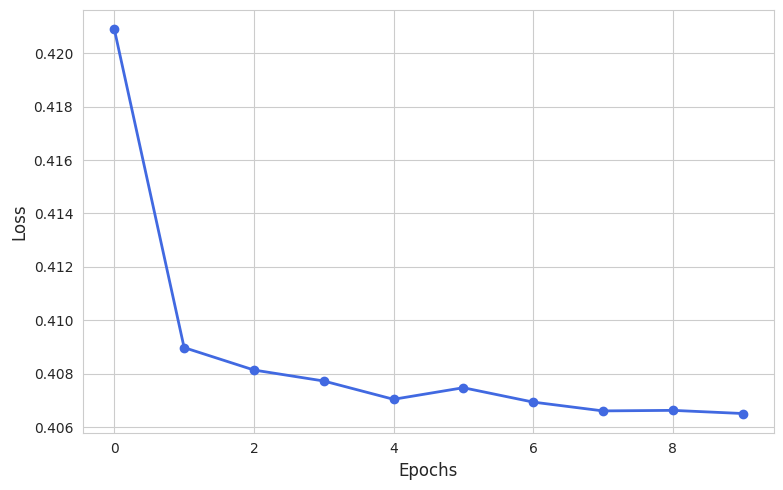

In [56]:
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# --- Plot 1: Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], marker='o', color='royalblue', linewidth=2, label='Train Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)



plt.tight_layout()
plt.show()

In [57]:


# 1. Create Test Loader
test_ds = HeteroGraphDataset(X, Y, test_idx, num_input_features, num_reactions)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, collate_fn=graph_collate_fn, num_workers=0)

model.eval()
total_test_tp = 0
total_test_fp = 0
total_test_fn = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        # 1. Forward Pass
        x_dict = {
            'patient': patient_lin(batch['patient'].x),
            'drug': drug_emb(torch.arange(num_input_features, device=device)),
            'reaction': react_emb(torch.arange(num_reactions, device=device))
        }
        
        out = model(x_dict, batch.edge_index_dict)
        

        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]
        
        pos_score = (src_emb * dst_emb).sum(dim=-1)
        
        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_score),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_score = (src_emb * neg_dst_emb).sum(dim=-1)
        
        # 4. Update Metrics (Threshold > 0)
        tp = (pos_score > 0).sum().item()
        fn = (pos_score <= 0).sum().item()
        fp = (neg_score > 0).sum().item() 
        
        total_test_tp += tp
        total_test_fp += fp
        total_test_fn += fn


epsilon = 1e-9
test_precision = total_test_tp / (total_test_tp + total_test_fp + epsilon)
test_recall = total_test_tp / (total_test_tp + total_test_fn + epsilon)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + epsilon)

print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

   Precision: 0.9449
   Recall:    0.9998
   F1-Score:  0.9716


In [58]:
def evaluate_hit_at_k(loader, k=10, num_negatives=99):
    model.eval()
    total_hits = 0
    total_examples = 0
    
    print(f"--- Running Harder Evaluation (Hit@{k} vs {num_negatives} negatives) ---")
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            
            x_dict = {
                'patient': patient_lin(batch['patient'].x),
                'drug': drug_emb(torch.arange(num_input_features, device=device)),
                'reaction': react_emb(torch.arange(num_reactions, device=device))
            }
            out = model(x_dict, batch.edge_index_dict)
            
            edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
            if edge_index.numel() == 0: continue
            
            src_emb = out['patient'][edge_index[0]] 
            dst_emb = out['reaction'][edge_index[1]] 
            
            pos_scores = (src_emb * dst_emb).sum(dim=-1) 
            
            neg_indices = torch.randint(0, num_reactions, (len(pos_scores), num_negatives), device=device)
            

            flat_neg_emb = out['reaction'][neg_indices.view(-1)]
            
            neg_emb = flat_neg_emb.view(len(pos_scores), num_negatives, -1)

            neg_scores = (src_emb.unsqueeze(1) * neg_emb).sum(dim=-1)
            
            all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
            
            _, indices = torch.sort(all_scores, descending=True, dim=1)
            
            hits = (indices[:, :k] == 0).any(dim=1).sum().item()
            
            total_hits += hits
            total_examples += len(pos_scores)
            
    final_score = total_hits / total_examples
    print(f"📊 Final Hit@{k} Score: {final_score:.2%}")
    return final_score

# Run the harder test
evaluate_hit_at_k(test_loader, k=10)

--- Running Harder Evaluation (Hit@10 vs 99 negatives) ---
📊 Final Hit@10 Score: 99.91%


0.9991319286911179